In [2]:
%pip install tensorflow_hub

In [12]:
import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras import layers

import matplotlib.pylab as plt
import tensorflow_datasets as tfds


In [13]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]WARNING:absl:1738 images were corrupted and were skipped


Dataset cats_vs_dogs downloaded and prepared to C:\Users\tuest\tensorflow_datasets\cats_vs_dogs\4.0.0. Subsequent calls will reuse this data.


In [14]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [18]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
IMAGE_RES = 224

feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [20]:
feature_extractor.trainable = False

In [21]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [22]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 776s 1s/step - loss: 0.0532 - accuracy: 0.9819 - val_loss: 0.0358 - val_accuracy: 0.9871
Epoch 2/6
582/582 [==============================] - 756s 1s/step - loss: 0.0290 - accuracy: 0.9903 - val_loss: 0.0308 - val_accuracy: 0.9895
Epoch 3/6
582/582 [==============================] - 895s 2s/step - loss: 0.0261 - accuracy: 0.9909 - val_loss: 0.0300 - val_accuracy: 0.9897
Epoch 4/6
582/582 [==============================] - 898s 2s/step - loss: 0.0214 - accuracy: 0.9926 - val_loss: 0.0320 - val_accuracy: 0.9901
Epoch 5/6
582/582 [==============================] - 924s 2s/step - loss: 0.0184 - accuracy: 0.9942 - val_loss: 0.0303 - val_accuracy: 0.9897
Epoch 6/6
582/582 [==============================] - 877s 1s/step - loss: 0.0172 - accuracy: 0.9939 - val_loss: 0.0333 - val_accuracy: 0.9890


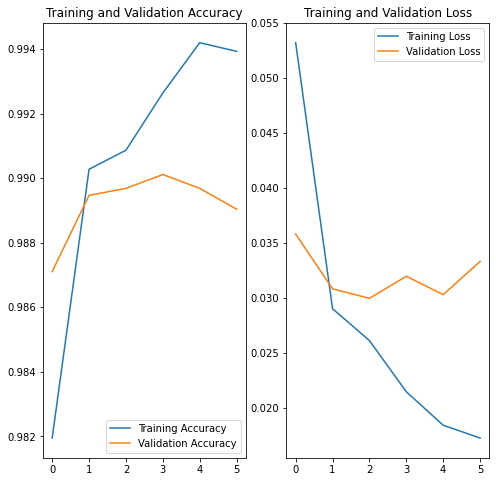

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
import numpy as np
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [29]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['background', 'background', 'tench', 'background', 'background',
       'background', 'background', 'background', 'background',
       'background', 'tench', 'background', 'tench', 'background',
       'background', 'tench', 'tench', 'background', 'background',
       'tench', 'background', 'background', 'background', 'tench',
       'tench', 'background', 'tench', 'background', 'tench',
       'background', 'tench', 'background'], dtype='<U30')

In [30]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'dog', 'cat', 'dog', 'cat', 'cat', 'dog', 'dog', 'cat',
       'cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'dog',
       'cat', 'dog', 'cat', 'dog', 'cat'], dtype='<U3')

In [31]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 1 1 0 1 0 1 0 1 0]
Predicted labels:  [0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 1 1 0 1 0 1 0 1 0]


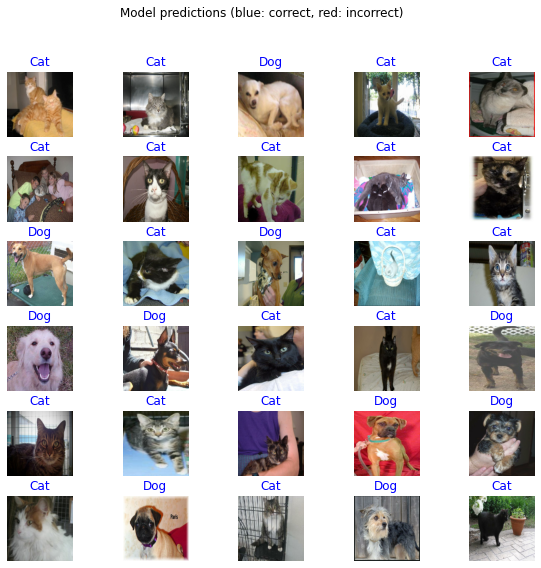

In [34]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

In [37]:
for i in range(len(model.weights)):
    model.weights[i]._handle_name = model.weights[i].name + "_" + str(i)

In [38]:
import time
t = time.time()

export_path_keras = f'./{int(t)}.h5'
print(export_path_keras)

model.save(export_path_keras)

./1673984039.h5


In [40]:
reloaded = tf.keras.models.load_model(
    export_path_keras,
    custom_objects={'KerasLayer': hub.KerasLayer}
)

reloaded.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [41]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [42]:
(abs(result_batch - reloaded_result_batch)).max()

0.0

In [53]:
for i in range(len(model.variables)):
    model.variables[i]._handle_name = str.replace(model.variables[i].name, f'_{i}', '')
    
t = time.time()

export_path_sm = f'./tf_{int(t)}'
print(export_path_sm)

tf.saved_model.save(model, export_path_sm)

./tf_1673984764
INFO:tensorflow:Assets written to: ./tf_1673984764\assets


INFO:tensorflow:Assets written to: ./tf_1673984764\assets


In [54]:
reloaded_sm = tf.saved_model.load(export_path_sm)
reloaded_sm_result_batch = reloaded_sm(image_batch, training=False).numpy()

In [55]:
(abs(result_batch - reloaded_sm_result_batch)).max()

0.0

https://stackoverflow.com/questions/66827371/difference-between-tf-saved-model-savemodel-path-to-dir-and-tf-keras-model-sa